In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
from gym import error, spaces, utils
from gym.utils import seeding
from kmcsim.buildtools import make_fcc, write_latt
import kmc_env
import kmcsim
from kmcsim.sim import KMCModel
from kmcsim.sim import EventTree
from kmcsim.sim import RunSim
import os
import numpy as np
import collections
from kmc_env.envs.kmcsim_state_funcs import make_surface_proj,calc_roughness,get_state_reward,get_incremented_rates,gaussian
from kmc_env.envs.kmc_env import *
from matplotlib import pyplot as plt
import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Reshape, Flatten, Add, Input
from keras.models import Model
from keras.layers import Concatenate
from IPython.display import clear_output
import time
import sys

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from kmcsim.buildtools import make_fcc, write_latt
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [19]:
class DQNAgent:
    def __init__(self, state_size, action_size,gamma=0.5,epsilon=0.8,epsilon_min=0,epsilon_decay=0.992):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = gamma    # discount rate
        self.epsilon = epsilon  # exploration rate
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Conv2D(32, activation='tanh', kernel_size = (3,3), strides = (1,1), batch_input_shape=(1,32,32,1)))
        model.add(MaxPool2D((2,2)))
        model.add(Conv2D(64, activation='tanh', kernel_size = (3,3), strides = (1,1), batch_input_shape=(1,32,32,1)))
        model.add(MaxPool2D((2,2)))
        model.add(Conv2D(32, activation='tanh', kernel_size = (3,3), strides = (1,1)))
        model.add(MaxPool2D((2,2)))
        model.add(Flatten())
        model.add(Dense(128, activation='tanh'))
        model.add(Dense(128, activation='tanh'))
        model.add(Dense(9, activation='linear'))
        model.compile(loss='mse', optimizer='adam', metrics=['mae'])
        #model.build()
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            action = [np.random.randint(0, 3), np.random.randint(0, 3), np.random.randint(0, 3)]
            decision=0

        else:
            action = [np.argmax(self.model.predict(state[None,:,:,None])[0][:3]),
                      np.argmax(self.model.predict(state[None,:,:,None])[0][3:6]),
                      np.argmax(self.model.predict(state[None,:,:,None])[0][6:])]
            decision=1
   
        return action,decision  # returns action

    def replay(self, batch_size):
        state, action, reward_new, next_state, done = self.memory[-1]
        ns_s=next_state[None,:,:,None]-next_state[None,:,:,None].mean()
        target = (reward_new + self.gamma *
                      np.amax(self.model.predict(ns_s)))
        s_s=state[None,:,:,None]-state[None,:,:,None].mean()
        target_f = self.model.predict(s_s)[0]
        target_f[action] = target
        self.model.fit(s_s, target_f.reshape(-1, 9), epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)




In [20]:
box = [16, 32, 4]
box_extension=32
target_roughness=0.98
EPISODES=150
wdir=r'C:\Users\ni1\Documents\RL\kmcsim\data\working'

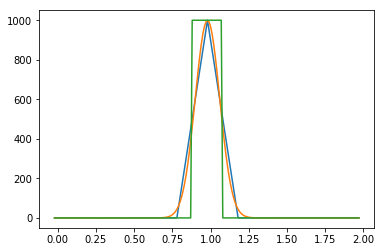

In [21]:
w=2

x=np.arange(-1,1,0.01)
y=1-np.abs(x*10*1/w)
y=y*1000
y[y<-1]=-1

y1=gaussian(x,sig=0.04*w,mu=0)*1000-1 

y2=np.ones_like(x)*1000
y2[x>0.05*w]=-1
y2[x<-0.05*w]=-1
plt.plot(x+target_roughness,y)
plt.plot(x+target_roughness,y1)
plt.plot(x+target_roughness,y2)
plt.show()

In [22]:
env = KmcEnv(box=box,box_extension=box_extension,target_roughness=target_roughness,
             reward_type='gaussian',reward_multiplier=1000,reward_tolerance=2,
             rates_spread=0.1,rates_adjustment=1,folder_with_params=wdir)
state,reward = env.reset()
state_size = env.state.shape
action_size = (3,)
agent = DQNAgent(state_size, action_size)

Current directory is C:\Users\ni1\Documents\RL


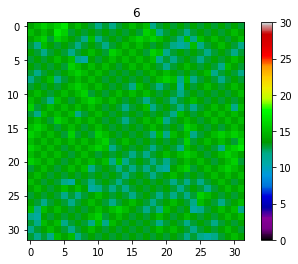

episode: 76/150, RMS: 1.066, score: 562.6, thickness: 13.74, e: 0.001689, decision: 1, done: 0


In [ ]:
done = False
batch_size = 1
env._max_episode_steps = None
for e in range(EPISODES):
    state,reward = env.reset()
    done=env.end_flag
    count=0
    while not done:
        if done:
            print("episode: {}/{}, RMS: {}, score: {}, e: {:.2}"
                  .format(e, EPISODES, rms_val, reward, agent.epsilon))
            break
            
        action, decision = agent.act(state)
        next_state, reward, done = env.step(action, verbose=False)
        agent.remember(state, action, reward, next_state, done)
        agent.replay(batch_size)
        state = next_state
        rms_val = calc_roughness(state)
        thickness=np.mean(state)
        clear_output(wait=True) 
        plt.title(count)
        plt.imshow(state,vmin=0,vmax=30,cmap='nipy_spectral')
        plt.colorbar()
        plt.show()
        print("episode: {}/{}, RMS: {:.4}, score: {:.4}, thickness: {:.4}, e: {:.4}, decision: {}, done: {}"
                  .format(e, EPISODES, rms_val, reward, thickness, agent.epsilon, decision, done))
        count=count+1


In [ ]:
agent.model.save('RL_DQN_0_98_adj_rates.h5')